In [1]:

!pip install transformers datasets torch torchvision kaggle


!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip


Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [2]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from transformers import ViTFeatureExtractor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, Trainer, TrainingArguments


np.random.seed(42)
torch.manual_seed(42)


metadata_path = '/content/HAM10000_metadata.csv'
skin_df = pd.read_csv(metadata_path)
print(skin_df.head())

le = LabelEncoder()
skin_df['label'] = le.fit_transform(skin_df['dx'])
print("Classes:", list(le.classes_))

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


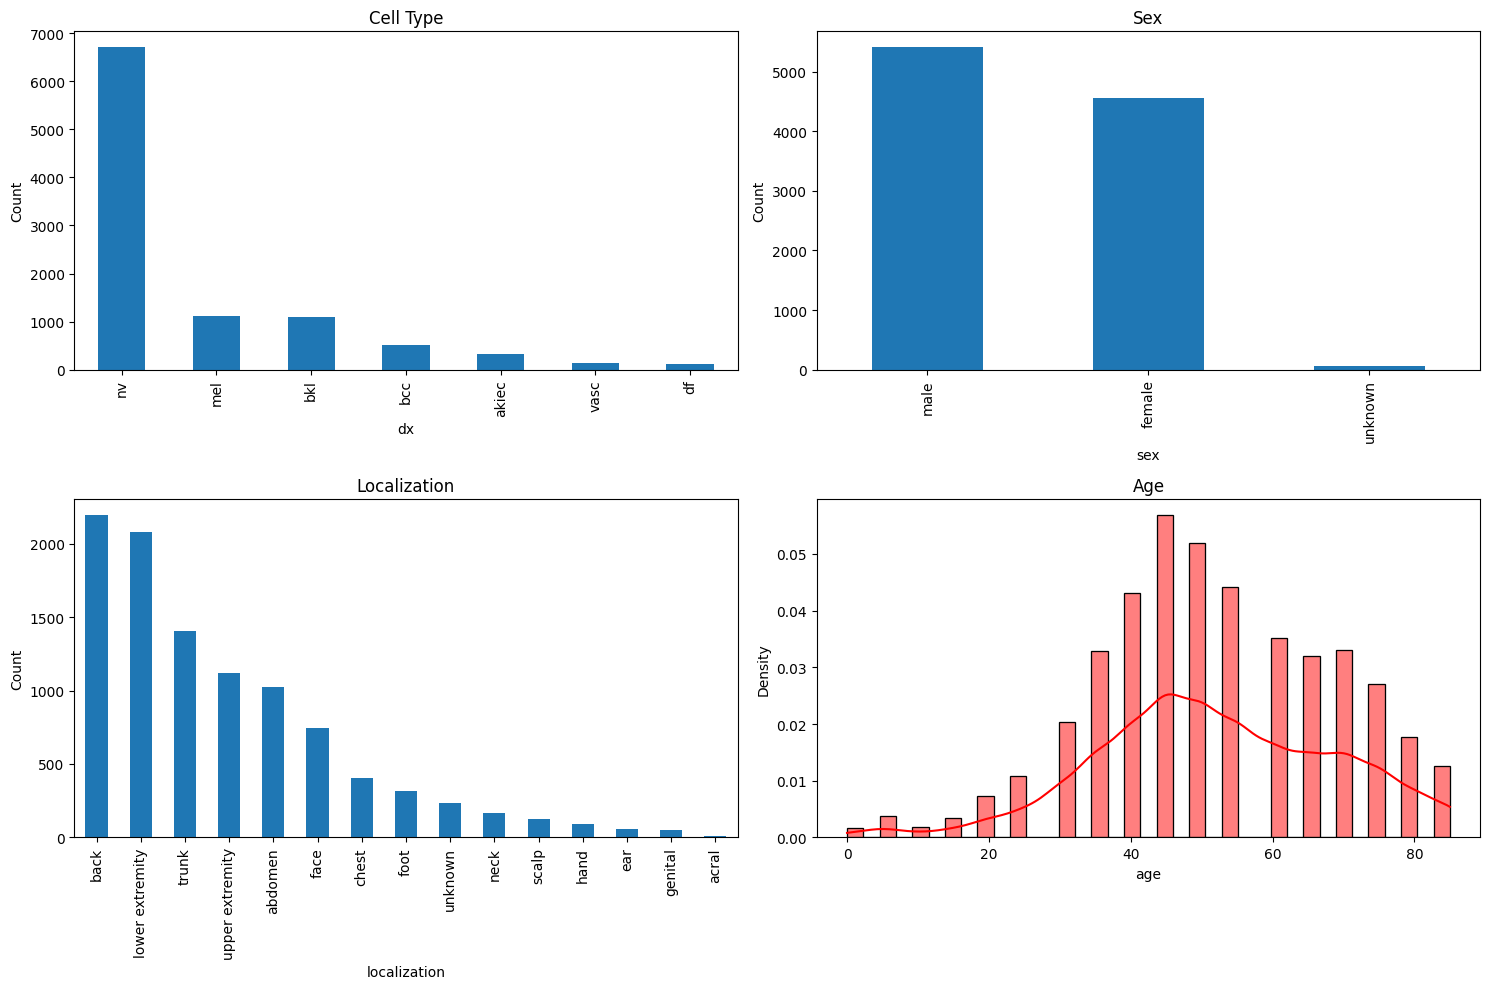

In [3]:

fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type')


ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count')
ax2.set_title('Sex')


ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_ylabel('Count')
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.histplot(sample_age['age'], kde=True, stat="density", color='red', ax=ax4)
ax4.set_title('Age')

plt.tight_layout()
plt.show()







Original label distribution:
label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64
Balanced label distribution:
label
2    500
5    500
3    500
4    500
6    500
1    500
0    500
Name: count, dtype: int64
          image_id                               image_path
861   ISIC_0029235  HAM10000_images_part_1/ISIC_0029235.jpg
7100  ISIC_0028977  HAM10000_images_part_1/ISIC_0028977.jpg
1045  ISIC_0028386  HAM10000_images_part_1/ISIC_0028386.jpg
122   ISIC_0032972  HAM10000_images_part_2/ISIC_0032972.jpg
467   ISIC_0026679  HAM10000_images_part_1/ISIC_0026679.jpg


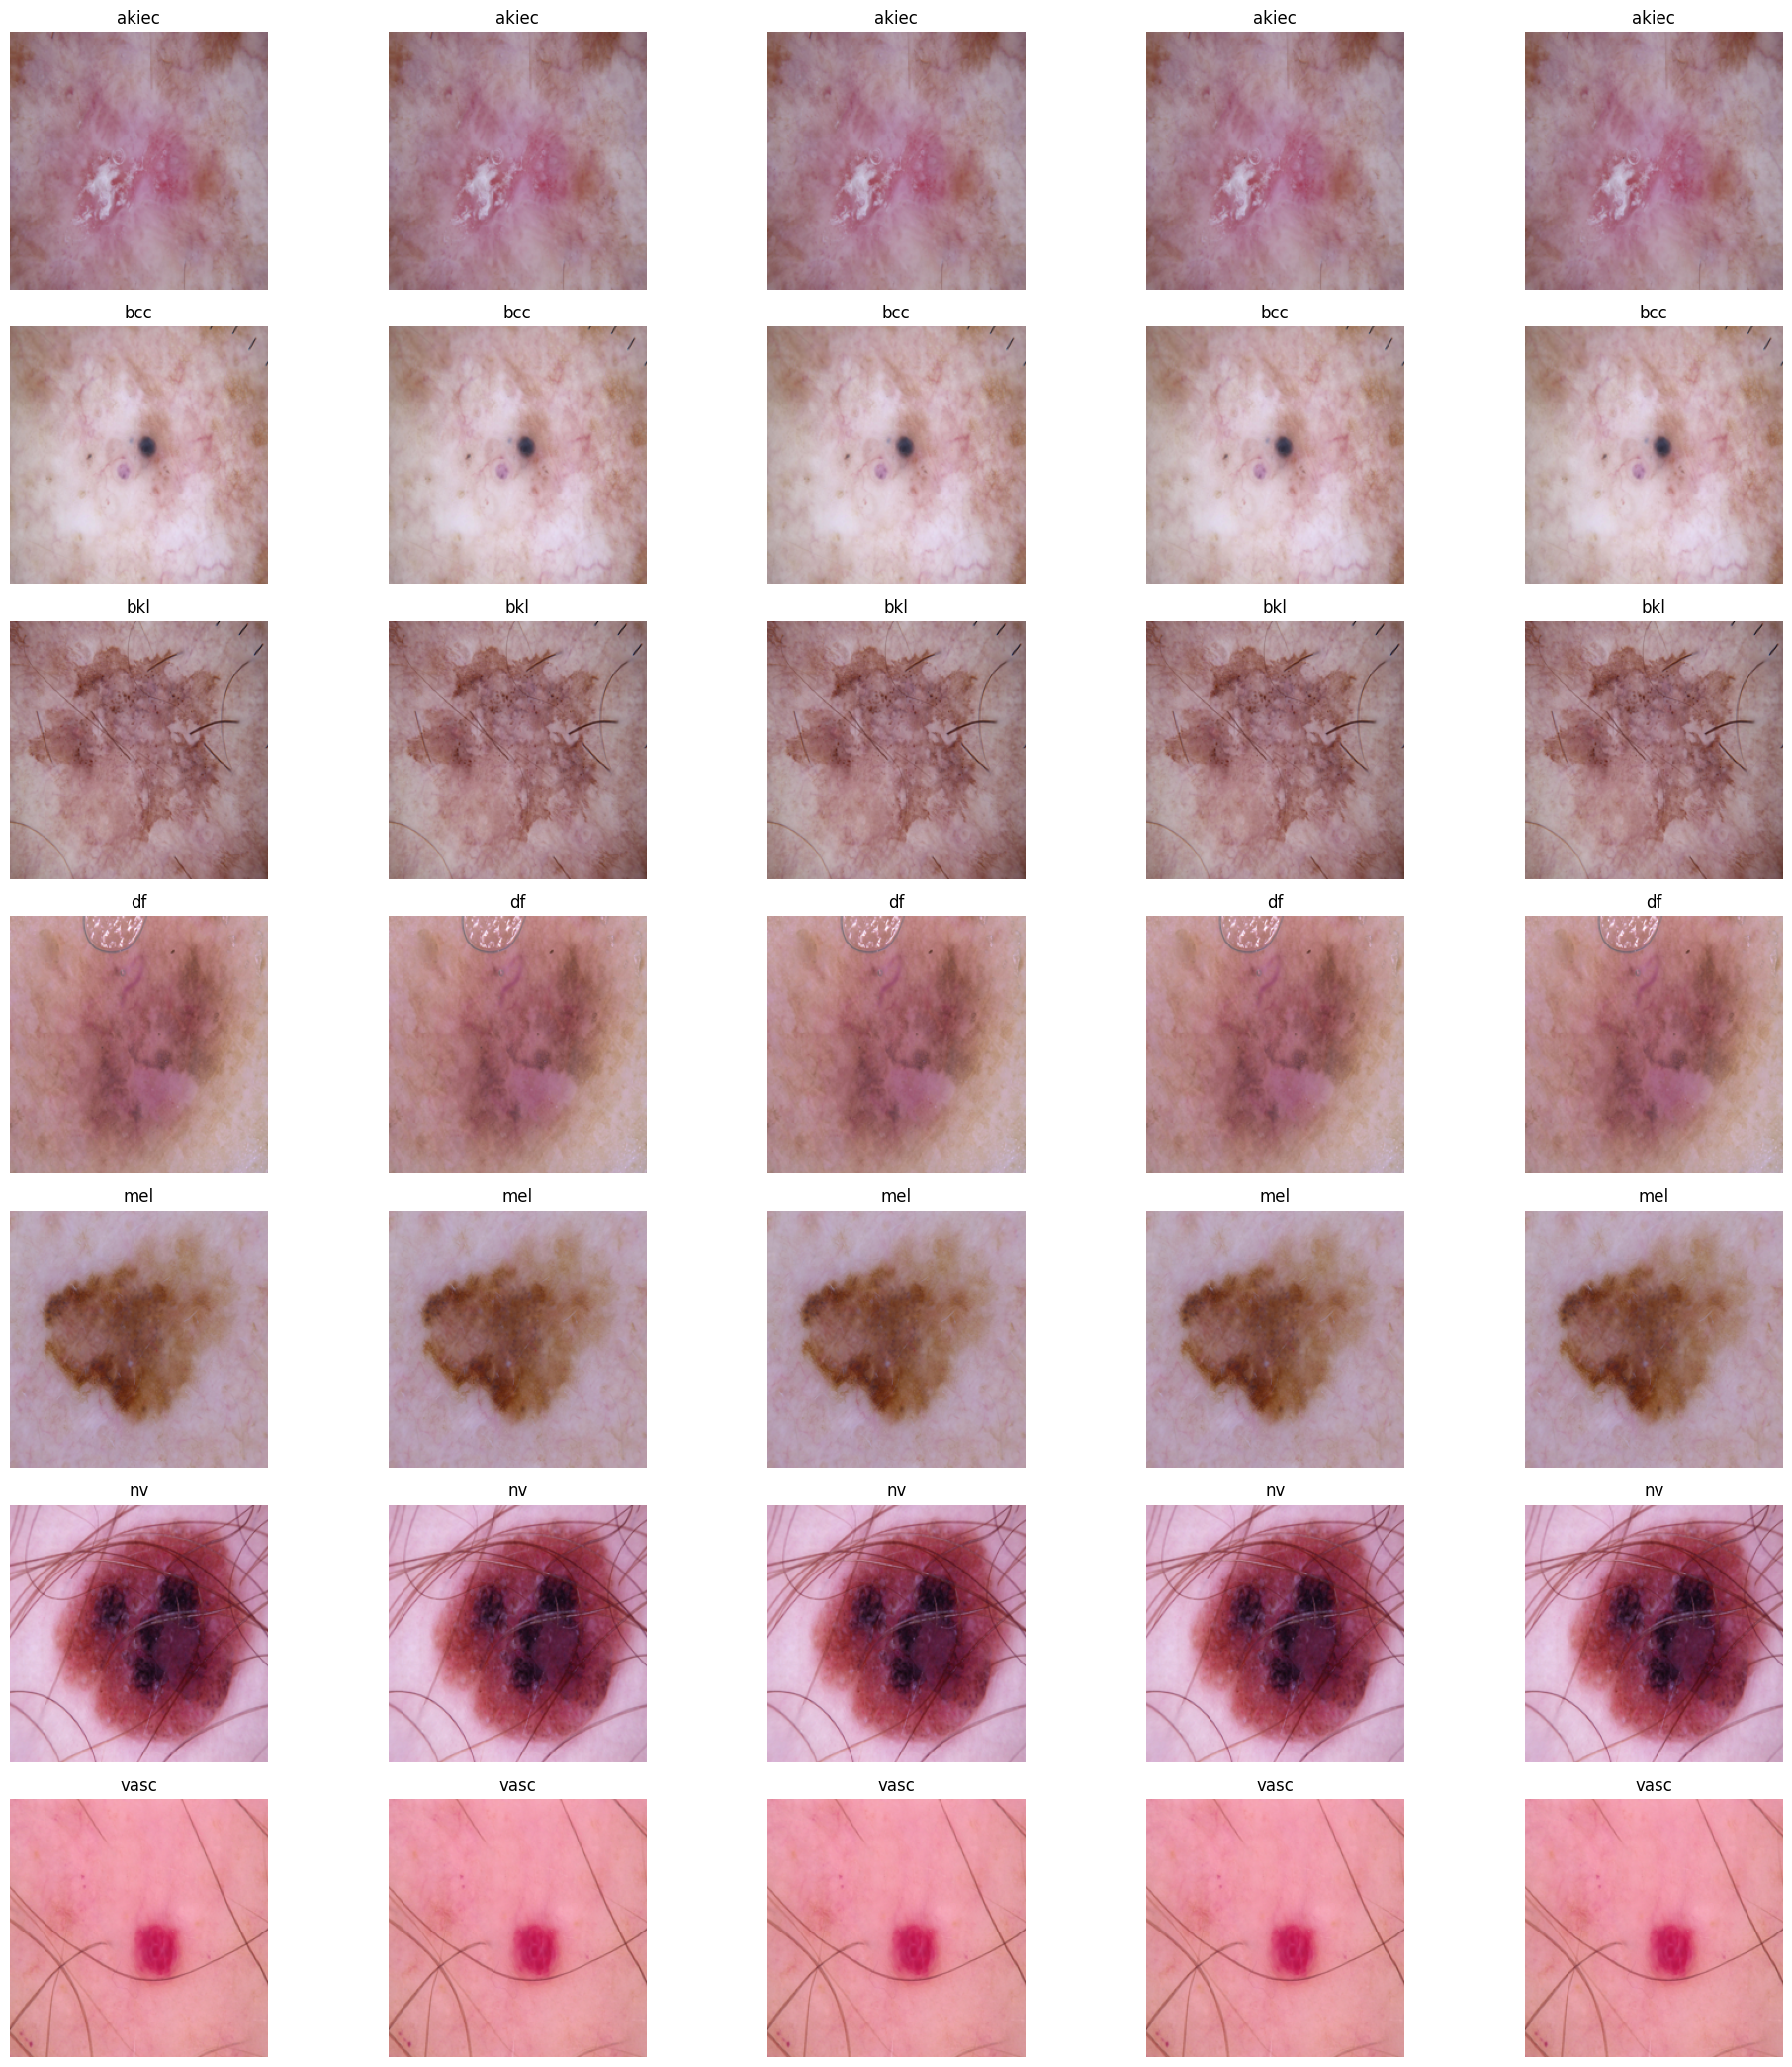

In [4]:
from sklearn.utils import resample
print("Original label distribution:")
print(skin_df['label'].value_counts())

n_samples = 500


df_list = []
for label in skin_df['label'].unique():
    df_label = skin_df[skin_df['label'] == label]
    df_balanced = resample(df_label, replace=True, n_samples=n_samples, random_state=42)
    df_list.append(df_balanced)

from glob import glob
import os

skin_df_balanced = pd.concat(df_list)
print("Balanced label distribution:")
print(skin_df_balanced['label'].value_counts())


image_dirs = ['HAM10000_images_part_1', 'HAM10000_images_part_2']
image_path_dict = {}
for dir_path in image_dirs:
    for img_file in glob(os.path.join(dir_path, '*.jpg')):
        img_id = os.path.splitext(os.path.basename(img_file))[0]
        image_path_dict[img_id] = img_file


skin_df_balanced['image_path'] = skin_df_balanced['image_id'].map(image_path_dict)
print(skin_df_balanced[['image_id', 'image_path']].head())


skin_df_balanced = skin_df_balanced.dropna(subset=['image_path'])


SIZE = 224

skin_df_balanced['image'] = skin_df_balanced['image_path'].map(
    lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE))) if pd.notnull(x) else None
)


n_samples_vis = 5
fig, m_axs = plt.subplots(len(le.classes_), n_samples_vis, figsize=(4*n_samples_vis, 3*len(le.classes_)))
for idx, (type_name, type_rows) in enumerate(skin_df_balanced.sort_values(['dx']).groupby('dx')):
    for n in range(n_samples_vis):
        c_row = type_rows.sample(1, random_state=42).iloc[0]
        ax = m_axs[idx, n]
        ax.imshow(c_row['image'])
        ax.set_title(type_name)
        ax.axis('off')

plt.tight_layout()
plt.show()




In [5]:
train_df, test_df = train_test_split(skin_df_balanced, test_size=0.2, random_state=42, stratify=skin_df_balanced['label'])


feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")


class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, feature_extractor):
        self.dataframe = dataframe.reset_index(drop=True)
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['image_path']).convert("RGB")  # Ensure 3-channel RGB
        label = row['label']


        inputs = self.feature_extractor(images=image, return_tensors="pt")


        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs["labels"] = torch.tensor(label, dtype=torch.long)
        return inputs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


          image_id                               image_path
861   ISIC_0029235  HAM10000_images_part_1/ISIC_0029235.jpg
7100  ISIC_0028977  HAM10000_images_part_1/ISIC_0028977.jpg
1045  ISIC_0028386  HAM10000_images_part_1/ISIC_0028386.jpg
122   ISIC_0032972  HAM10000_images_part_2/ISIC_0032972.jpg
467   ISIC_0026679  HAM10000_images_part_1/ISIC_0026679.jpg


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.056100,0.997110,0.755714,0.745480,0.753759,0.755714
2,0.587700,0.628378,0.857143,0.857448,0.858617,0.857143
3,0.416300,0.506810,0.867143,0.864652,0.864719,0.867143
4,0.314600,0.455508,0.870000,0.868484,0.874654,0.870000
5,0.180200,0.390844,0.892857,0.892719,0.895015,0.892857
6,0.110900,0.389500,0.891429,0.890257,0.890800,0.891429
7,0.060700,0.381445,0.902857,0.902205,0.902449,0.902857
8,0.043400,0.385432,0.904286,0.904705,0.906250,0.904286
9,0.036000,0.384279,0.904286,0.904111,0.904563,0.904286
10,0.029600,0.396051,0.904286,0.904111,0.904563,0.904286


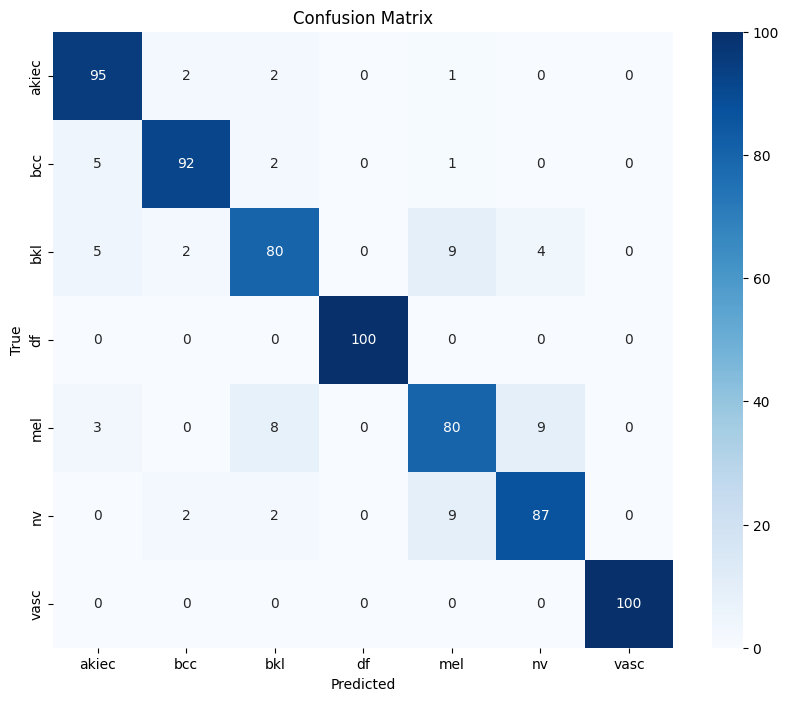

In [7]:
train_dataset = SkinCancerDataset(train_df, feature_extractor)
test_dataset = SkinCancerDataset(test_df, feature_extractor)



train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


print(skin_df_balanced[['image_id', 'image_path']].head())


model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(le.classes_),
    id2label={str(i): label for i, label in enumerate(le.classes_)},
    label2id={label: i for i, label in enumerate(le.classes_)}
)


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)


from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


trainer.train()


trainer.evaluate()


trainer.save_model("./vit-skin-cancer-classifier")


predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids


cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()